In [74]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.layers import Concatenate
from collections import deque
import random
from quanser.hardware import HIL 
from pal.products.qube import QubeServo3
from pal.utilities.math import SignalGenerator, ddt_filter
from pal.utilities.scope import Scope
from threading import Thread
import time
import signal

In [75]:
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.float32),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32))
    def size(self):
        return len(self.buffer)
    
def soft_update(target_weights, online_weights, tau=0.005):
    for (target, online) in zip(target_weights, online_weights):
        target.assign(target * (1 - tau) + online * tau) 

replay_buffer = ReplayBuffer()

In [76]:
state_size = 4
action_size = 1
gamma = 0.99 # discount rate
learning_rate = 0.001 # learning rate

# Define the actor model
states_inputs = Input(shape=(state_size,))
dense = Dense(32, activation='relu')(states_inputs)
dense = Dense(32, activation='relu')(dense)
outputs = Dense(action_size, activation='tanh')(dense)
outputs = keras.layers.Lambda(lambda x: x * 2.5)(outputs)  
actor_model = Model(inputs=states_inputs, outputs=outputs)

# Critic 1
state_input1 = Input(shape=(state_size,))
action_input1 = Input(shape=(action_size,))
concat1 = Concatenate()([state_input1, action_input1])
dense1 = Dense(32, activation='relu')(concat1)
dense1 = Dense(32, activation='relu')(dense1)
sigmoid_layer = Dense(1, activation='linear')(dense1)
output1 = Dense(1)(sigmoid_layer)
critic_model1 = Model([state_input1, action_input1], output1)

# Critic 2
state_input2 = Input(shape=(state_size,))
action_input2 = Input(shape=(action_size,))
concat2 = Concatenate()([state_input2, action_input2])
dense2 = Dense(32, activation='relu')(concat2)
dense2 = Dense(32, activation='relu')(dense2)
sigmoid_layer2 = Dense(1, activation='linear')(dense2)
output2 = Dense(1)(sigmoid_layer2)
critic_model2 = Model([state_input2, action_input2], output2)

# try:
#     actor_model.load_weights('saves/quanser/actor_model.weights.h5')
#     critic_model1.load_weights('saves/quanser/critic_model1.weights.h5')
#     critic_model2.load_weights('saves/quanser/critic_model2.weights.h5')
# except:
#     pass

actor_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
critic_optimizer1 = tf.keras.optimizers.Adam(learning_rate=learning_rate)
critic_optimizer2 = tf.keras.optimizers.Adam(learning_rate=learning_rate)

target_actor = keras.models.clone_model(actor_model)
target_actor.set_weights(actor_model.get_weights())

target_critic1 = keras.models.clone_model(critic_model1)
target_critic1.set_weights(critic_model1.get_weights())
target_critic2 = keras.models.clone_model(critic_model2)
target_critic2.set_weights(critic_model2.get_weights())

ckpt = tf.train.Checkpoint(actor_optimizer=actor_optimizer,
                           critic_optimizer1=critic_optimizer1, 
                           critic_optimizer2=critic_optimizer2)

# Restore the latest checkpoint with optimizer states
ckpt.restore(tf.train.latest_checkpoint("saves/quanser/optimizers_ckpt")).expect_partial()



In [77]:
# # squareWave = SignalGenerator().square(np.pi/4, 5)
# # next(squareWave)
# k_p, k_d = (4.000, 0.175)
# frequency = 500  # Hz
# state_theta_dot = np.array([0,0], dtype=np.float64)
# state_alpha_dot = np.array([0,0], dtype=np.float64)
# with QubeServo3(hardware = 1, pendulum = 1, frequency=frequency) as board:
#     while True:
#         # Have to initialize the board first before reading motorPosition or it won't read
#         board.read_outputs()
#         theta = board.motorPosition 
#         alpha = -board.pendulumPosition 
        
#         if np.abs(theta) > np.pi/4:
#             pen = 500
#         else:
#             pen = 0

#         theta_dot, state_theta_dot = ddt_filter(theta, state_theta_dot, 50, 1/frequency)
#         # u - input
#         # state - previous state returned by this function -- initialize to np.array([0,0], dtype=np.float64)
#         # Ts - sample time in seconds
#         # A - filter bandwidth in rad/s
#         alpha_dot, state_alpha_dot = ddt_filter(alpha, state_alpha_dot, 100, 1/frequency)
#         reward = -((
#                     alpha**2
#                 ))
#         reward = float(reward - pen) 
#         print(f"Theta: {theta:.3f}, Theta dot: {theta_dot:.3f}, Alpha: {alpha:.3f}, Alpha dot: {alpha_dot:.3f}", 
#               f"Reward: {reward:.3f}")
# #         time.sleep(0.5)

C:\Users\ntk00\AppData\Local\Temp\ipykernel_27296\2255423053.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward = float(reward - pen)


Epoch 1, Total Reward: -12.3059, Q1: 0.0000, Q2: 0.0000, TargetQ: 0.0000 alpha: -3.1416 alpha_dot: -285.5993 voltage: 2.21 theta: -0.0000 theta_dot: 0.0000
Epoch 2, Total Reward: -10.1326, Q1: 0.0000, Q2: 0.0000, TargetQ: 0.0000 alpha: -3.1416 alpha_dot: -191.1863 voltage: 2.93 theta: -0.0000 theta_dot: 0.0000
Epoch 3, Total Reward: -9.8824, Q1: 0.0000, Q2: 0.0000, TargetQ: 0.0000 alpha: -3.1416 alpha_dot: -127.9842 voltage: 2.77 theta: -0.0031 theta_dot: -0.1322
Epoch 4, Total Reward: -9.9741, Q1: 0.0000, Q2: 0.0000, TargetQ: 0.0000 alpha: -3.1416 alpha_dot: -85.6754 voltage: 2.32 theta: -0.0031 theta_dot: -0.1082
Epoch 5, Total Reward: -9.8316, Q1: 0.0000, Q2: 0.0000, TargetQ: 0.0000 alpha: -3.1355 alpha_dot: -56.8459 voltage: 2.28 theta: -0.0061 theta_dot: -0.2208
Epoch 6, Total Reward: -9.9071, Q1: 0.0000, Q2: 0.0000, TargetQ: 0.0000 alpha: -3.1324 alpha_dot: -37.7749 voltage: 2.72 theta: -0.0123 theta_dot: -0.4590
Epoch 7, Total Reward: -9.7552, Q1: 0.0000, Q2: 0.0000, TargetQ: 0.

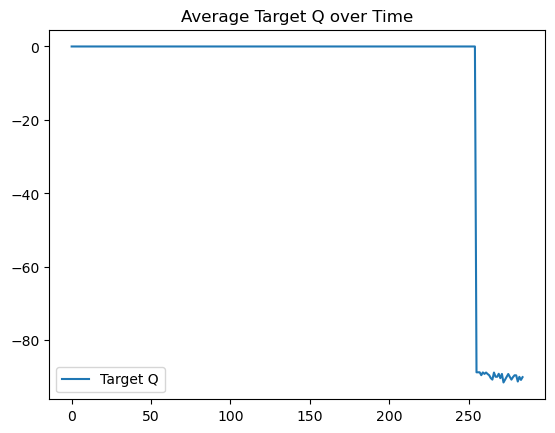

In [ ]:
batch_size = 1024
history = []
policy_delay = 2  # Delayed policy updates
step = 0
total_reward = 0.0
frequency = 500  # Hz
state_theta_dot = np.array([0,0], dtype=np.float64)
state_alpha_dot = np.array([0,0], dtype=np.float64)

prev_action = np.zeros(action_size, dtype=np.float32)
avg_q = []
step_in_episode = 0

try: 
    with QubeServo3(hardware = 1, pendulum = 1, frequency=500) as board:
        while True:
            board.read_outputs()
            theta = board.motorPosition * -1
            alpha = board.pendulumPosition 
            alpha = np.mod(alpha, 2*np.pi) - np.pi
            theta_dot, state_theta_dot = ddt_filter(theta, state_theta_dot, 50, 1/frequency)
            alpha_dot, state_alpha_dot = ddt_filter(alpha, state_alpha_dot, 100, 1/frequency)
            state = np.array([theta, theta_dot, alpha, alpha_dot], dtype=np.float32)

            for _ in range(1): # steps per control action
                avg_q1, avg_q2, avg_target_q = 0.0, 0.0, 0.0
                step += 1 
                
                action = actor_model(tf.convert_to_tensor([state], dtype=tf.float32)).numpy()[0]
                action = action + np.random.normal(0, 0.3, size=action_size)  # Add exploration noise
                board.write_voltage(action)
                
                # scopeVoltage.sample(timeStamp, np.array(action).reshape(-1)[0])

                board.read_outputs()
                next_theta = board.motorPosition * -1
                next_alpha = board.pendulumPosition
                next_alpha = np.mod(next_alpha, 2*np.pi) - np.pi
                next_theta_dot, state_theta_dot = ddt_filter(next_theta, state_theta_dot, 50, 1/frequency)
                next_alpha_dot, state_alpha_dot = ddt_filter(next_alpha, state_alpha_dot, 100, 1/frequency)
                next_state = np.array([next_theta, next_theta_dot, next_alpha, next_alpha_dot], dtype=np.float32)
                
                if np.abs(theta) > np.pi/4:
                    pen = 100
                else:
                    pen = 0

                delta_u = action - prev_action
                reward = -((
                    alpha**2 +
                    0.5 * delta_u**2
                ))
                prev_action = action.copy()
                reward = float(reward - pen) 
                total_reward += reward

                replay_buffer.store(state, action, reward, next_state, False)
                state = next_state

            if replay_buffer.size() >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = tf.convert_to_tensor(states, dtype=tf.float32)
                actions = tf.convert_to_tensor(actions, dtype=tf.float32)
                rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
                next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
                dones = tf.convert_to_tensor(dones, dtype=tf.float32) 

                # add clipped noise to target action
                noise = tf.random.normal(shape=tf.shape(actions), mean=0.0, stddev=0.3, dtype=tf.float32)
                next_actions = target_actor(next_states) + noise
                next_actions = tf.clip_by_value(next_actions, -2.0, 2.0)

                # Compute target Q-values with both critics
                target1 = tf.squeeze(target_critic1([next_states, next_actions]), axis=1)
                target2 = tf.squeeze(target_critic2([next_states, next_actions]), axis=1)
                target_q = rewards + gamma * (1 - dones) * tf.minimum(target1, target2)
                # target_q = tf.clip_by_value(target_q, 0, 1e8)
                target_q = tf.expand_dims(target_q, axis=1)  # shape (batch,1)
                
                with tf.GradientTape() as tape_critic1, tf.GradientTape() as tape_critic2:
                    q1 = critic_model1([states, actions], training=True)
                    q2 = critic_model2([states, actions], training=True)

                    # Compute losses
                    loss1 = tf.keras.losses.MSE(target_q, q1)
                    loss2 = tf.keras.losses.MSE(target_q, q2)

                avg_q1 = tf.reduce_mean(q1).numpy().item()
                avg_q2 = tf.reduce_mean(q2).numpy().item()
                avg_target_q = tf.reduce_mean(target_q).numpy().item()

                # Get gradients for each critic once
                critic_grad1 = tape_critic1.gradient(loss1, critic_model1.trainable_variables)
                critic_grad2 = tape_critic2.gradient(loss2, critic_model2.trainable_variables)

                # Apply gradients
                critic_optimizer1.apply_gradients(zip(critic_grad1, critic_model1.trainable_variables))
                critic_optimizer2.apply_gradients(zip(critic_grad2, critic_model2.trainable_variables))
                if step % policy_delay == 0:  # Delayed policy updates
                    with tf.GradientTape() as tape_actor: 
                        action = actor_model(states)
                        actor_loss = -tf.reduce_mean(critic_model1([states, action]))

                    actor_grad = tape_actor.gradient(actor_loss, actor_model.trainable_variables)
                    actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))

                    soft_update(target_actor.variables, actor_model.variables, tau=0.005)
                    soft_update(target_critic1.variables, critic_model1.variables, tau=0.005)
                    soft_update(target_critic2.variables, critic_model2.variables, tau=0.005)

            history.append(total_reward)
            if step % 1 == 0:
                avg_q.append(avg_target_q)
                print(f"Epoch {step}, Total Reward: {float(reward):.4f}, "
                f"Q1: {avg_q1:.4f}, Q2: {avg_q2:.4f}, TargetQ: {avg_target_q:.4f}", 
                f"alpha: {alpha:.4f}", f"alpha_dot: {alpha_dot:.4f}", 
                f"voltage: {np.array(action).reshape(-1)[0]:.2f}", 
                f"theta: {theta:.4f}", f"theta_dot: {theta_dot:.4f}")
except KeyboardInterrupt:
    print("\nStopping (Ctrl+C). Saving…")
finally:
    actor_model.save_weights("saves/quanser/actor_model.weights.h5")
    critic_model1.save_weights("saves/quanser/critic_model1.weights.h5")
    critic_model2.save_weights("saves/quanser/critic_model2.weights.h5")
    ckpt = tf.train.Checkpoint(actor_optimizer=actor_optimizer,
                           critic_optimizer1=critic_optimizer1,
                           critic_optimizer2=critic_optimizer2)
    ckpt.save("saves/quanser/optimizers_ckpt/ckpt")
    plt.title("Average Target Q over Time")
    plt.plot(avg_q, label='Target Q')
    plt.legend()
    print("Done.")